In [1]:
import pandas as pd 
import numpy as np
import os 

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split 
from sklearn.metrics import hamming_loss, make_scorer
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_validate, GridSearchCV, KFold
import warnings 
warnings.filterwarnings('ignore')

# Model Training

## functions

In [33]:
def df_optimized(df, verbose=True):
    in_size = df.memory_usage(index=True).sum()
    for type in ["float", "integer"]:
        l_cols = list(df.select_dtypes(include=type))
        for col in l_cols:
            df[col] = pd.to_numeric(df[col], downcast=type)
            df[col] = round(df[col],4)
            if type == "float":
                df[col] = pd.to_numeric(df[col], downcast="integer")
    out_size = df.memory_usage(index=True).sum()
    df.replace({False: 0, True: 1}, inplace=True) # converting bool into int 
    ratio = (1 - round(out_size / in_size, 2)) * 100
    GB = out_size / 1000000000
    if verbose:
        print("optimized size by {} % | {} GB".format(ratio, GB))
    return df

## custom loss function 
hamming_loss_neg = make_scorer(lambda y_true, y_pred: 1-hamming_loss(y_true,y_pred))

In [99]:
def get_data_filepath(filename):
    return os.path.join(os.path.dirname(__file__), 'data', filename)

In [100]:
def recall(y_pred,y_test):
    
    y_pred = pd.DataFrame(y_pred, columns = y_test.columns)
    y_test.reset_index(drop=True, inplace = True)

    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for col in y_pred:
        for i in range(len(y_pred[col])):
            if y_pred[col][i] == y_test[col][i] == 1:
                TP += 1
            elif y_pred[col][i] == y_test[col][i] == 0:
                TN += 1
            elif y_pred[col][i] == 1 and y_test[col][i] == 0:
                FP += 1
            elif y_pred[col][i] == 0 and y_test[col][i] == 1:
                FN += 1
    return TP/(FN+TP)  # TP, FP, TN, FN 

In [101]:
def custom_predict(X_test, custom_threshold):
    prob_list = []
    y_preds_prob = clf.predict_proba(X_test) # clf is the model 
    for col in y_preds_prob:
        probs = col[:,1] # each columns - accessing all the rows, first index of the list. 
        prob_list.append((probs > custom_threshold).astype('int8'))
    return pd.DataFrame(np.array(prob_list).transpose(),columns = y_test.columns)

In [102]:
def get_data():
    df =  pd.read_csv("../ddi/data/final_dataset.csv")
    df.drop(columns =[col for col in df.columns if 'Unnamed' in col], inplace = True)
    df.drop(columns = ['26','87'], inplace = True)
    df = df_optimized(df)
    return df

In [103]:
def preprocess(df):
    X = abs(df[df.columns[89:]])  # check with marcus what are X and y columns -
    y = df[df.columns[3:89]]
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3 )

    '''scaling_train X'''
    std_scaler = StandardScaler()
    std_scaler.fit(X_train)
    X_train = pd.DataFrame(std_scaler.transform(X_train), columns = X.columns)

    '''pca_transform'''
    pca = PCA(n_components = 150)
    pca.fit(X_train)
    X_train = pca.transform(X_train)

    X_test = std_scaler.transform(X_test)
    X_test = pca.transform(X_test)

    return X_train, X_test, y_train, y_test

In [104]:
def train(X_train,y_train):
    forest = RandomForestClassifier(n_estimators=100, random_state=1)
    clf = MultiOutputClassifier(forest, n_jobs = -2)
    clf.fit(X_train,y_train)
    return clf

In [105]:
def test(X_test,y_test):
    y_pred = clf.predict(X_test)
    accuracy = 1 - hamming_loss(y_test,y_pred)
    return accuracy

In [91]:
def train_full(df):
    X = df[df.columns[89:]]  # check with marcus what are X and y columns -
    y = df[df.columns[3:89]]

    std_scaler = StandardScaler()
    std_scaler.fit_transform(X)
    pca = PCA(n_components = 150)
    pca.fit(X)
    X = pca.transform(X)
    
    model = train(X,y)
    
    return pca, model## pca

## Importing Files

In [106]:
df = get_data()

optimized size by 69.0 % | 0.12910421 GB


In [107]:
df

,DD_ID,Drug1,Drug2,0,1,2,3,4,5,6,...,SRW09,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb2
0,100113,100,113,0,0,1,0,1,0,1,...,7.2218,1.1304,74.0895,1186.603394,3.7356,197200007879,41,158,175,4.1250
1,100123,100,123,1,0,1,0,1,0,1,...,0.0000,2.2652,33.0284,270.221802,5.4149,2102,38,114,133,5.3333
2,100144,100,144,0,0,0,0,1,0,1,...,0.0000,0.6562,3.8462,24.952101,0.7735,468,8,26,41,0.1944
3,100211,100,211,0,0,1,0,0,0,0,...,7.1952,0.0887,1.6073,173.085907,0.0307,1732,11,40,33,2.9722
4,100213,100,213,1,0,1,0,1,0,1,...,7.0501,0.1302,4.7457,125.101196,0.8477,1459,6,30,23,2.2500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63468,744737,744,737,0,0,0,0,1,0,0,...,0.0000,6.5265,21.9259,15.935800,36.7537,15,0,18,15,0.0000
63469,744739,744,739,1,0,1,0,1,1,1,...,0.0000,7.6251,27.4189,22.020300,17.7757,99999984,0,20,16,1.0000
63470,744740,744,740,0,0,0,0,1,0,0,...,0.0000,7.6251,27.4189,57.924000,12.8524,99999984,0,20,16,1.0000
63471,744742,744,742,1,0,0,0,1,1,1,...,0.0000,7.6251,27.4189,37.994202,9.7887,99999984,0,20,16,1.0000


In [83]:
X_train, X_test, y_train, y_test = preprocess(df)

In [84]:
clf = train(X_train,y_train)

In [85]:
test(X_test,y_test)

0.7627521048941996

In [92]:
pca, clf = train_full(df)

In [51]:
clf.predict()

MultiOutputClassifier(estimator=RandomForestClassifier(random_state=1),
                      n_jobs=-1)

## Grid search 

In [30]:
def grid_train(X_train,y_train):
    hamming_loss_neg = make_scorer(lambda y_true, y_pred: 1-hamming_loss(y_true,y_pred))
    
    rfc = RandomForestClassifier()
    clf = MultiOutputClassifier(rfc)

    param_grid = {
        "estimator__bootstrap": [True,False],
        'estimator__max_depth': [2,3],
        'estimator__max_features': [2, 3],
        'estimator__min_samples_leaf': [2, 4],
        'estimator__min_samples_split': [2, 4],
        'estimator__n_estimators': [10,20,30]
    }

    search = GridSearchCV(estimator = clf, param_grid = param_grid, 
                              cv = 2, n_jobs = -2, verbose = 1, scoring=hamming_loss_neg)
    
    search.fit(X_train, y_train)
    
    return search

In [44]:
hamming_loss_neg = make_scorer(lambda y_true, y_pred: 1-hamming_loss(y_true,y_pred))

rfc = RandomForestClassifier()
clf = MultiOutputClassifier(rfc)

param_grid = {
    "estimator__bootstrap": [True,False],
    'estimator__max_depth': [2,3],
    'estimator__max_features': [2, 3],
    'estimator__min_samples_leaf': [2, 4],
    'estimator__min_samples_split': [2, 4],
    'estimator__n_estimators': [10,20,30]
}

search = GridSearchCV(estimator = clf, param_grid = param_grid, 
                          cv = 2, n_jobs = -2, verbose = 1, scoring=hamming_loss_neg)

search.fit(X_train, y_train)

Fitting 2 folds for each of 96 candidates, totalling 192 fits


GridSearchCV(cv=2,
             estimator=MultiOutputClassifier(estimator=RandomForestClassifier()),
             n_jobs=-2,
             param_grid={'estimator__bootstrap': [True, False],
                         'estimator__max_depth': [2, 3],
                         'estimator__max_features': [2, 3],
                         'estimator__min_samples_leaf': [2, 4],
                         'estimator__min_samples_split': [2, 4],
                         'estimator__n_estimators': [10, 20, 30]},
             scoring=make_scorer(<lambda>), verbose=1)

In [45]:
best_model = search.best_estimator_

In [47]:
search.best_estimator_

MultiOutputClassifier(estimator=RandomForestClassifier(max_depth=3,
                                                       max_features=3,
                                                       min_samples_leaf=2,
                                                       n_estimators=30))

In [ ]:
#     param_grid = {
#         "estimator__bootstrap": [True,False],
#         'estimator__max_depth': [2,3],
#         'estimator__max_features': [2, 3],
#         'estimator__min_samples_leaf': [2, 4],
#         'estimator__min_samples_split': [2, 4],
#         'estimator__n_estimators': [100, 120, 130]
#     }

In [ ]:
# dropping columns that has too many 0s 
# col_list = []
# for col in y.columns:
#     if y[col].value_counts()[0]/len(y[col]) > 0.9:
#         col_list.append(col)
# y = y.drop(columns =col_list)

## Random Forest

In [ ]:
forest = RandomForestClassifier(n_estimators=10, random_state=1)
clf = MultiOutputClassifier(forest, n_jobs =-1)
clf.fit(X_train,y_train)

In [ ]:
y_pred = clf.predict(X_test)
accuracy = 1 - hamming_loss(y_test,y_pred) 
accuracy

In [56]:
recall(y_pred,y_test)

0.5435252884946304

In [57]:
updated_preds = custom_predict(X_test,0.3)

In [45]:
recall(updated_preds,y_test)

0.5468337626347546

## XGB Classifier

In [87]:
xgbclass = GradientBoostingClassifier(n_estimators=10, learning_rate=0.1, max_depth=3, verbose = 1)
clf2 = MultiOutputClassifier(xgbclass, n_jobs =-1)
clf2.fit(X_train,y_train)

MultiOutputClassifier(estimator=GradientBoostingClassifier(n_estimators=10,
                                                           verbose=1),
                      n_jobs=-1)

In [88]:
y_pred = clf2.predict(X_test)
accuracy = 1-hamming_loss(y_test,y_pred)
accuracy

0.74897896603636

In [293]:
# from sklearn import linear_model
# clf = linear_model.Lasso(alpha=0.1)
# clf.fit(X_train,y_train)

## PCA 

In [68]:
std_scaler = StandardScaler()
std_scaler.fit(X_train)
X_train = pd.DataFrame(std_scaler.transform(X_train), columns = X.columns)

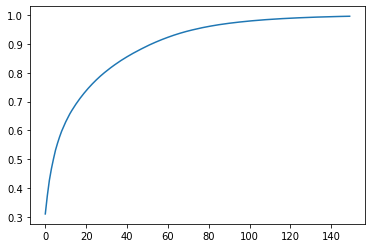

In [69]:
pca = PCA(n_components = 150)
pca.fit(X_train)
pca_x_train = pca.transform(X_train)
# plt.plot(np.cumsum(pca.explained_variance_ratio_)) 

### PCA Random Forest 

In [76]:
forest = RandomForestClassifier(n_estimators=100, random_state=1)
clf = MultiOutputClassifier(forest, n_jobs = -1)
clf.fit(pca_x_train,y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(random_state=1),
                      n_jobs=-1)

In [77]:
X_test = std_scaler.transform(X_test)
pca_X_test = pca.transform(X_test)

In [78]:
y_pred_pca = clf.predict(pca_X_test)
accuracy = 1-hamming_loss(y_test,y_pred_pca) 
accuracy

0.35364241274705455

### Cross Validate

In [ ]:
forest = RandomForestClassifier(n_estimators=10, random_state=1)
clf = MultiOutputClassifier(forest)
k_fold = KFold(n_splits=3, shuffle=True, random_state=42)

# make_scorer returns a callable scores for the estimator's output - used in GridSearchCV and cross_val_score
cv_results = cross_validate(clf, X, y, cv=k_fold, scoring = hamming_loss_neg, n_jobs = -3 )
cv_results['test_score']

### GridSearch

In [57]:
hamming_loss_neg = make_scorer(lambda y_true, y_pred: 1-hamming_loss(y_true,y_pred))

In [ ]:
rfc = RandomForestClassifier()
clf = MultiOutputClassifier(rfc)

param_grid = {
    "estimator__bootstrap": [True,False],
    'estimator__max_depth': [2,3],
    'estimator__max_features': [2, 3],
    'estimator__min_samples_leaf': [2, 4],
    'estimator__min_samples_split': [2, 4],
    'estimator__n_estimators': [100, 120, 130]
}

search = GridSearchCV(estimator = clf, param_grid = param_grid, 
                          cv = 2, n_jobs = -3, verbose = 1, scoring=hamming_loss_neg)

search.fit(pca_x_train, y_train)

Fitting 2 folds for each of 96 candidates, totalling 192 fits


In [17]:
search.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [ ]:
search.best_score_

### PCA XGB Classifier

In [ ]:
xgbclass = GradientBoostingClassifier(n_estimators=15, learning_rate=0.1, max_depth=4, verbose = 1)
clf2 = MultiOutputClassifier(xgbclass, n_jobs = -1)
clf2.fit(X_train_pca,y_train_pca)

In [ ]:
y_pred_pca = clf2.predict(X_test_pca)
accuracy = 1-hamming_loss(y_test_pca,y_pred_pca)
accuracy

# User Interface

In [93]:
from mordred import Calculator, descriptors
from rdkit import Chem
from urllib.request import urlopen
from urllib.parse import quote

In [94]:
Y_class= pd.read_csv("../raw_data/mt_reclassification_encoded.csv",
                     usecols = ['sub_system_severity','Y_cat'],
                    nrows = 1307) # remove rows 

In [95]:
def get_side_effects(drug1,drug2):

    '''converting drug names to smiles, return try again error if cant process the drug names'''
    smile_list = []
    for drug in [drug1,drug2]:
        try: 
            url = 'http://cactus.nci.nih.gov/chemical/structure/' + quote(drug) + '/smiles'
            ans = urlopen(url).read().decode('utf8')
            smile_list.append(ans)
        except:
            return 'Unable to find the drug, please try again.'
    
    '''building pandas dataframe'''
    mols = [Chem.MolFromSmiles(item) for item in smile_list]
    calc = Calculator(descriptors, ignore_3D=True)
    drug_features = calc.pandas(mols)
    
    
    '''cleaning drug_features dataframe'''
    drug_features.replace({False: 0, True: 1}, inplace=True)
    drug_features = drug_features[df.columns[88:]]
    drug_features.iloc[0] = drug_features.iloc[0].astype("float32")
    drug_features.iloc[1] = drug_features.iloc[1].astype("float32")
    X_test = pd.DataFrame(drug_features.iloc[0] - drug_features.iloc[1]).astype('float32').transpose()
    '''need to transform X_test'''
    X_test = pca.transform(X_test) ## 
    
    '''predicting X_test with the model'''
    y_pred = clf.predict(X_test) # model.joblib 
    
    '''creating a dictionary that returns the sub_system as values '''
    cat_dict = pd.Series(Y_class.sub_system_severity.values, index = Y_class.Y_cat).to_dict()
    
    '''retrieving the predicted categories and store into a list'''
    prediction_list = []
    for i,x in enumerate(y_pred[0]):
        if x == 0:
            continue
        prediction_list.append(i)
    
    '''retrieving the side_effects given the predicted categories'''
    side_effect_list = []
    for i in prediction_list:
        side_effect_list.append(cat_dict[i])
    
    return side_effect_list

In [96]:
get_side_effects('Aspirin','Aspirin')

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


KeyError: "None of [Index(['86', 'ABC_diff', 'ABCGG_diff', 'nAcid_diff', 'nBase_diff',\n       'nAromAtom_diff', 'nAromBond_diff', 'nAtom_diff', 'nHeavyAtom_diff',\n       'nSpiro_diff',\n       ...\n       'SRW09_diff', 'SRW10_diff', 'TSRW10_diff', 'MW_diff', 'AMW_diff',\n       'WPath_diff', 'WPol_diff', 'Zagreb1_diff', 'Zagreb2_diff',\n       'mZagreb2_diff'],\n      dtype='object', length=722)] are in the [columns]"

In [ ]:
def save_model(model):
    # saving the trained model to disk is mandatory to be able to upload it to storage
    if model == 'model':
        joblib.dump(model, 'model.joblib')
        print("saved model.joblib locally")
    else:
        joblib.dump(model,'pca.joblib')
        print("saved pca.joblib locally")